In [2]:
#Import libraries
import os
import string
import math
import numpy as np
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from numpy import *
import scipy.constants
from decimal import Decimal


if os.name == "nt":
    dirDelim = "\\"
else:
    dirDelim = "/"

# Adjust the plot line thickness, tick mark thickness, etc.
matplotlib.rcParams['axes.linewidth'] = 1.5
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['xtick.minor.size'] = 5
matplotlib.rcParams['xtick.minor.width'] = 2
matplotlib.rcParams['xtick.minor.size'] = 5
matplotlib.rcParams['ytick.minor.width'] = 2

In [3]:
"""
FAST COOLING SHOCK BUBBLE (t=10^2,10^4,10^6,10^8,10^10)
Gas velocity equations from Weaver1977
Initial parameters and shock feature equations from FG2012
"""

#Initial parameters
#alpha= 1.0 #0 < alpha < 2
alpha_W= 0.921 #dimensionless constant
L_AGN = 10.0**46.0 #erg/s = (g*cm^2/s^2)/s
nH_0= 100.0 # particles/cm^3
rho_0 = nH_0*(scipy.constants.m_p*1000.0) #g/cm^3
vin= 30000.0*(10.0**5.0) #cm/s, was 30000.0 km/s
R0= 100.0*(3.086*(10.0**18)) #cm, was pc for all numerical sim
Tin = 1.0
c= scipy.constants.c*(100.0) #cm/s, was 300000000.0 m/s
L_in=(0.5)*L_AGN*Tin*(vin/c)

#Calculate density for corresponding v at (t=10^2,10^4,10^6,10^8,10^10)
M_out = ((10.0**(-6.0))*((1.989*(10.0**30.0))*1000.0))/(3.154*(10.0**7.0)) #g/s, was M_0/yr
p_t={}
        
#Constants derived for energy conserving shock in FG2012 AppendixA
def A_E(alpha):
    A_E = ((((5.0-alpha)**2.0)*(3.0-alpha)*L_in)/(36.0*np.pi*rho_0*(R0**alpha)))**(1.0/(5.0-alpha))
    return A_E
def Beta_E(alpha):
    Beta_E = 3.0/(5.0-alpha)
    return Beta_E

In [4]:
t=[]
R2_t=[];vsh1_t=[];R1_t=[];Rc_t=[]
vgas1_t = {}; r_t = {}

alpha= 0.0

for i in range(5):
    
    #Determine timesteps using range 10^2 yr < t < 10^9 yr
    t.append((10.0**(2.0*(i+1)))*(3.154*(10.0**7.0))) #s, was 10^2 yr < t < 10^9 yr
    
    #Calculate R2 and Vsh (Weaver)
    #R2_t.append(alpha_W*((L_in*(t[i]**3.0))/rho_0)**0.2)
    #vsh_t.append((3.0/5.0)*alpha_W*((L_in)/(rho_0*(t[i]**2.0)))**0.2)
        
    #Calculate radius of shock bubble features based on t (FG2012)
    R2_t.append(A_E(alpha)*(t[i]**Beta_E(alpha)))
    vsh1_t.append(((3.0/2.0)*(((3.0-alpha)*L_AGN*Tin*vin)/((5.0-alpha)*np.pi*c*(R0**alpha)*rho_0))**(1.0/3.0))*R2_t[i]**((alpha-2.0)/3.0))
    
    coeff = [1.0, 0.5*vin*t[i], 0, -((R2_t[i])**3.0)]
    roots=np.roots(coeff)
    real_root = roots[np.isreal(roots)].real
    for j in range(np.size(real_root)):
        if real_root[j] > 0:
            R1_t.append(float(real_root[j]))
    
    Rc_t.append(0.86*R2_t[i])
    
    #Calculate

    num= 10000
    radius = np.linspace(10.0**(17.0),R2_t[i],num) #cm, was 10^-1 pc < R < 10^4 pc
    vgas = []

    #Calculate vgas in different regions of shock bubble (Weaver1977)
    for r in radius:
        if r<R1_t[i]:
            vgas.append(vin)
        elif r==R1_t[i]:
            vgas.append(vin/4.0)
        elif R1_t[i]<r<Rc_t[i]:
            #vgas.append((vin/4.0)*((R1_t[i]/r)**2.0))
            vgas.append((11.0/25.0)*((Rc_t[i]**3.0)/((r**2.0)*t[i]))+(4.0/25.0)*(r/t[i]))
            vgas_neg = (11.0/25.0)*((Rc_t[i]**3.0)/((r**2.0)*t[i]))+(4.0/25.0)*(r/t[i])
        elif r==Rc_t[i]:
            vgas.append(0.86*vsh1_t[i])
        elif Rc_t[i]<r<R2_t[i]:
            #Assuming linear
            vgas.append((vsh1_t[i]/(Rc_t[i]-R2_t[i]))*((0.11*r)+(0.75*Rc_t[i])-(0.86*R2_t[i])))
        elif r==R2_t[i]:
            vgas.append(0.75*vsh1_t[i])
        else:
            vgas.append(0.0)
    
    if i>0:
        vgas_pos = (0.86*vsh1_t[i])
        #print("vgas- = " + str(vgas_neg))
        #print("vgas+ = " + str(vgas_pos))
        #print("vgas- / vgas+ = " + str(vgas_neg/vgas_pos))
    
    #Convert t from s to yrs, R from cm to pc, and vgas from cm/s to km/s
    t[i]=t[i]/(3.154*(10.0**7.0))
    R1_t[i]= R1_t[i]/(3.086*(10.0**18)); Rc_t[i]= Rc_t[i]/(3.086*(10.0**18)); R2_t[i]= R2_t[i]/(3.086*(10.0**18))

    for j in range(0,len(radius)):
        radius[j]= radius[j]/(3.086*(10.0**18))
        vgas[j]=vgas[j]/(10.0**5.0)
        
    vgas1_t[i+1] = vgas
    r_t[i+1] = radius


In [5]:
t=[]
R2_t=[];vsh2_t=[];R1_t=[];Rc_t=[]
vgas2_t = {}; r_t = {}

alpha= 0.0

for i in range(5):
    
    #Determine timesteps using range 10^2 yr < t < 10^9 yr
    t.append((10.0**(2.0*(i+1)))*(3.154*(10.0**7.0))) #s, was 10^2 yr < t < 10^9 yr
    
    #Calculate R2 and Vsh (Weaver)
    #R2_t.append(alpha_W*((L_in*(t[i]**3.0))/rho_0)**0.2)
    #vsh_t.append((3.0/5.0)*alpha_W*((L_in)/(rho_0*(t[i]**2.0)))**0.2)
        
    #Calculate radius of shock bubble features based on t (FG2012)
    R2_t.append(A_E(alpha)*(t[i]**Beta_E(alpha)))
    vsh2_t.append((Beta_E(alpha)*R2_t[i])/(t[i]))
    
    coeff = [1.0, 0.5*vin*t[i], 0, -((R2_t[i])**3.0)]
    roots=np.roots(coeff)
    real_root = roots[np.isreal(roots)].real
    for j in range(np.size(real_root)):
        if real_root[j] > 0:
            R1_t.append(float(real_root[j]))
    
    Rc_t.append(0.86*R2_t[i])
    
    #Calculate

    num= 10000
    radius = np.linspace(10.0**(17.0),R2_t[i],num) #cm, was 10^-1 pc < R < 10^4 pc
    vgas = []

    #Calculate vgas in different regions of shock bubble (Weaver1977)
    for r in radius:
        if r<R1_t[i]:
            vgas.append(vin)
        elif r==R1_t[i]:
            vgas.append(vin/4.0)
        elif R1_t[i]<r<Rc_t[i]:
            #vgas.append((vin/4.0)*((R1_t[i]/r)**2.0))
            vgas.append((11.0/25.0)*((Rc_t[i]**3.0)/((r**2.0)*t[i]))+(4.0/25.0)*(r/t[i]))
            vgas_neg = (11.0/25.0)*((Rc_t[i]**3.0)/((r**2.0)*t[i]))+(4.0/25.0)*(r/t[i])
        elif r==Rc_t[i]:
            vgas.append(0.86*vsh2_t[i])
        elif Rc_t[i]<r<R2_t[i]:
            #Assuming linear
            vgas.append((vsh2_t[i]/(Rc_t[i]-R2_t[i]))*((0.11*r)+(0.75*Rc_t[i])-(0.86*R2_t[i])))
        elif r==R2_t[i]:
            vgas.append(0.75*vsh2_t[i])
        else:
            vgas.append(0.0)
    
    if i>0:
        vgas_pos = (0.86*vsh2_t[i])
        #print("vgas- = " + str(vgas_neg))
        #print("vgas+ = " + str(vgas_pos))
        #print("vgas- / vgas+ = " + str(vgas_neg/vgas_pos))
    
    #Convert t from s to yrs, R from cm to pc, and vgas from cm/s to km/s
    t[i]=t[i]/(3.154*(10.0**7.0))
    R1_t[i]= R1_t[i]/(3.086*(10.0**18)); Rc_t[i]= Rc_t[i]/(3.086*(10.0**18)); R2_t[i]= R2_t[i]/(3.086*(10.0**18))

    for j in range(0,len(radius)):
        radius[j]= radius[j]/(3.086*(10.0**18))
        vgas[j]=vgas[j]/(10.0**5.0)
        
    vgas2_t[i+1] = vgas
    r_t[i+1] = radius



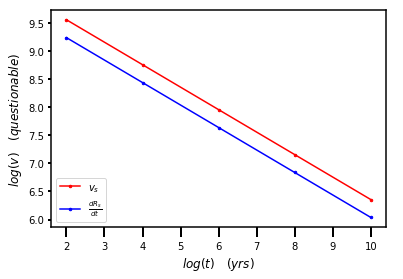

In [7]:
#Plot vs and dRs/dt vs time
plt.plot(np.log10(t),np.log10(vsh1_t),color='red',linestyle="-",marker='.',markersize=5,label=r'$v_s$')
plt.plot(np.log10(t),np.log10(vsh2_t),color='blue',linestyle="-",marker='.',markersize=5,label=r'$\frac{dR_s}{dt}$')
plt.legend(loc='lower left')
plt.ylabel(r'$log(v) \quad (questionable)$', fontsize=12)
plt.xlabel(r'$log(t) \quad (yrs)$', fontsize=12)
plt.savefig('Weaver&FGShockBubble_logvshVSlogt.png',bbox_inches='tight')
plt.show()

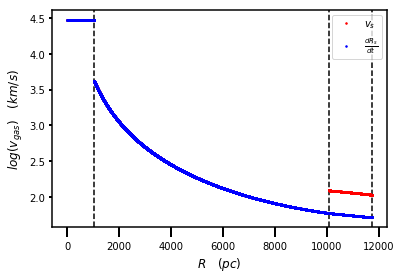

In [9]:
#Plot log(v_gas) vs R for set time
plt.axvline(x=R1_t[3],color='black',linestyle="--")
plt.axvline(x=Rc_t[3],color='black',linestyle="--")
plt.axvline(x=R2_t[3],color='black',linestyle="--")
plt.plot(r_t[4],np.log10(vgas1_t[4]),color='red',linestyle="",marker='.',markersize=3,label=r'$v_s$')
plt.plot(r_t[4],np.log10(vgas2_t[4]),color='blue',linestyle="",marker='.',markersize=3,label=r'$\frac{dR_s}{dt}$')
plt.legend(loc='upper right')
plt.ylabel(r'$log(v_{gas}) \quad (km/s)$', fontsize=12)
plt.xlabel(r'$R \quad (pc)$', fontsize=12)
plt.savefig('Weaver&FGShockBubble_logvgasVSr_t10^8_TEST.png',bbox_inches='tight')
plt.show()

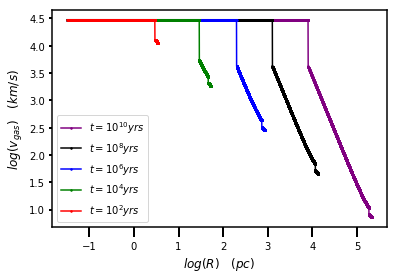

In [22]:
#Plot log(v_gas) vs log(r) for different t steps
plt.plot(np.log10(r_t[5]),np.log10(vgas_t[5]),color='purple',linestyle="-",marker='.',markersize=3,label=r'$t=10^{10} yrs$')
plt.plot(np.log10(r_t[4]),np.log10(vgas_t[4]),color='black',linestyle="-",marker='.',markersize=3,label=r'$t=10^{8} yrs$')
plt.plot(np.log10(r_t[3]),np.log10(vgas_t[3]),color='blue',linestyle="-",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
plt.plot(np.log10(r_t[2]),np.log10(vgas_t[2]),color='green',linestyle="-",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
plt.plot(np.log10(r_t[1]),np.log10(vgas_t[1]),color='red',linestyle="-",marker='.',markersize=3,label=r'$t=10^{2} yrs$')
plt.legend(loc='lower left')
plt.ylabel(r'$log(v_{gas}) \quad (km/s)$', fontsize=12)
plt.xlabel(r'$log(R) \quad (pc)$', fontsize=12)
plt.savefig('Weaver&FGShockBubble_logvgasVSlogr_t10^2-10^10.png',bbox_inches='tight')
plt.show()